# <u> Architectural Plan GAN Generator </u>

# Setup

In [1]:
import tensorflow as tf
import keras

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
# To generate GIFs
# pip install imageio
# pip install git+https://github.com/tensorflow/docs

## Load Dataset

#### 500 x 500 dataset

In [3]:
folder_path = r"C:\Users\johnd\Desktop\Dataset\Archidata\1600 Dataset\Expanded Dataset 100 x 100"
images = []
for filename in os.listdir(folder_path):
    full_filename = os.path.join(folder_path, filename)
    with PIL.Image.open(full_filename) as image:
        new_image = image.convert(mode='L')
        images.append(np.asarray(new_image))
        
#images = np.asarray(images)

In [4]:
np.asarray(images).shape

(1600, 100, 100)

In [5]:
images[1].shape

(100, 100)

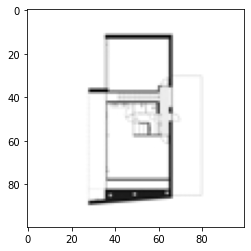

In [6]:
plt.imshow((images[170]),cmap="gray")

In [7]:
train_images = np.stack(images, axis = 0)
train_images = train_images.reshape(train_images.shape[0],100,100,1)

In [8]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [9]:
train_images.shape

(1600, 100, 100, 1)

## Buffer and Batch size

In [10]:
# Split dataset and Shuffle
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 400
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Models

## Generator Model

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 25, 256)))
    assert model.output_shape == (None, 25, 25, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 100, 100, 1)

    return model

In [12]:
generator = make_generator_model()

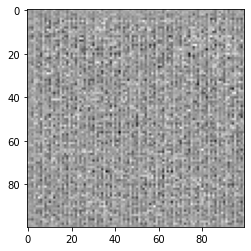

In [13]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator Model

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

In [16]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00016751]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the training loop

In [22]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#     print("generator loss: ",np.mean(gen_loss))
#     print("discriminator loss: ",np.mean(disc_loss))

In [24]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    # Produce image every 10 epochs
    if (epoch + 1) % 10 == 0:
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

    # Save the model every 500 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
# def train(dataset, epochs):
#   for epoch in range(epochs):
#     start = time.time()

#     for image_batch in dataset:
#       train_step(image_batch)

#     # Produce images for the GIF as you go
#     display.clear_output(wait=True)
#     generate_and_save_images(generator,
#                              epoch + 1,
#                              seed)

#     # Save the model every 100 epochs
#     if (epoch + 1) % 1000 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#   # Generate after the final epoch
#   display.clear_output(wait=True)
#   generate_and_save_images(generator,
#                            epochs,
#                            seed)

## Generate and save images

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# <u>Restore checkpoint </u>

In [29]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Manual load generator and discriminator models

In [26]:
generator = keras.models.load_model(r'C:\Users\johnd\Desktop\GANs\Plan Generation 100 x 100\Saved Models\ArchiGAN_Generator.h5')
discriminator = keras.models.load_model(r'C:\Users\johnd\Desktop\GANs\Plan Generation 100 x 100\Saved Models\ArchiGAN_Discriminator.h5')

### Manual save models

In [101]:
generator.save(r'C:\Users\johnd\Desktop\GANs\Plan Generation 100 x 100\Saved Models\ArchiGAN_Generator.h5')
discriminator.save(r'C:\Users\johnd\Desktop\GANs\Plan Generation 100 x 100\Saved Models\ArchiGAN_Discriminator.h5')

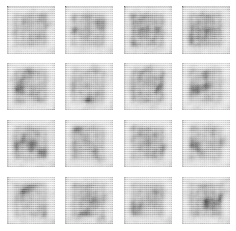

In [27]:
train(train_dataset, 100)

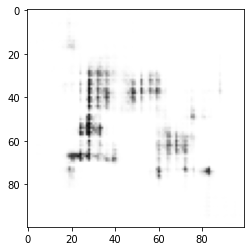

In [198]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

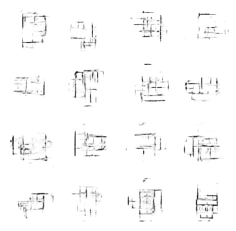

In [199]:
train(train_dataset, 2000)

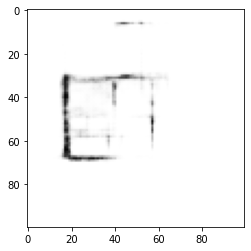

In [704]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

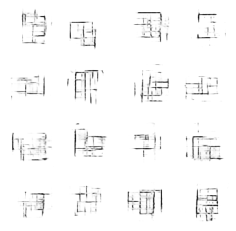

In [736]:
train(train_dataset, 600)

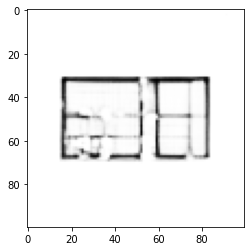

In [146]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

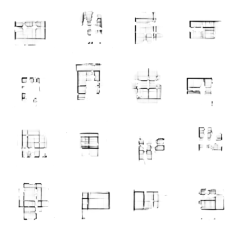

In [67]:
train(train_dataset, 10000)

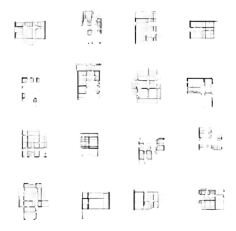

In [167]:
train(train_dataset, 1000)

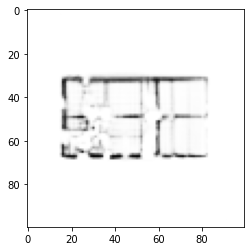

In [164]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

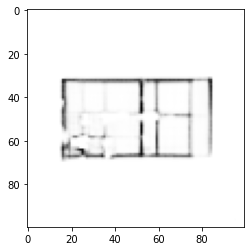

In [175]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

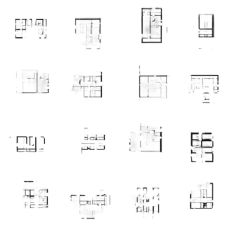

In [52]:
train(train_dataset, 2000)

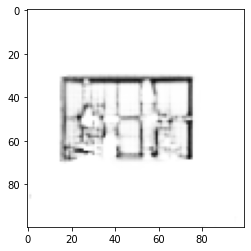

In [355]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

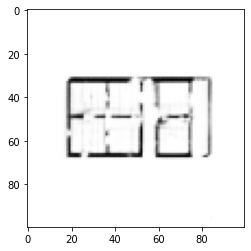

In [97]:
plt.imshow(generator(np.random.rand(1,100)).numpy().reshape(100,100),cmap="gray")

## Create GIF

In [98]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

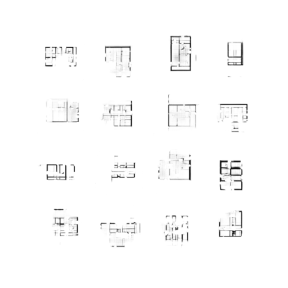

In [99]:
display_image(2000)

In [100]:
anim_file = '21.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)